# [Final Project Option 2] Phase Transition
Sihan Ren, Chuyan Zhou, Junye Wang

# References
## GPT
+ Helped to complete the code of Ising model (10%)
+ Provided the idea of generating gif animations for simulations (20%)
+ Debug helper and reminder of new tools (such as nbmerge for notebook)
## Resources from Web or papers
+ [1] [Ising model](https://en.wikipedia.org/wiki/Ising_model)
+ [2] [Markov Random Field](https://en.wikipedia.org/wiki/Markov_random_field)
+ [3] [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling)
## Python External Libraries
+ [1] [numpy](https://numpy.org/)
+ [2] [matplotlib](https://matplotlib.org/)
+ [3] [tqdm](https://en.wikipedia.org/wiki/Markov_random_field)
+ [4] [FuncAnimation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation)

# Part I: Percolation
---
## Task Allocation
- Sihan Ren

## Description
We use Monte Carlo simulation to estimate percolation threshold. The task will consist of the following parts:
1. Simulation of percolation process
2. Monte Carlo simulation
3. Comparison


## 1.Simulation of percolation process
Under the guidance of the project specification, we construct an $n\times n$ grid to simulate percolation. At each step, we let a random site open and check once to see if the grid percolate. At last, use the fraction of sites that are opened when percolates as the probability $p$, which represents the probability that a site is open in the original problem. Our code is implemented as follows:
- Using a $n\times n$ np_array `_grid` to represent the grid, if `_grid[i][j]==0` the $(i,j)$ site is blocked, otherwise `_grid[i][j]==1` means $(i,j)$ site is opened.
- Given $n$, the `PercolationGrid` class is initialized. We first initialize an $n\times n$ np_array with all zero, and then we'll record the coordinates of each site using a list `block_list` and shuffle it.
- When we need to open a site, just pop the first item of `block_list`, then set the value of coorsponding site in the grid to one. At the same time, we'll update `open_num` to keep track of how many sites are currently opened. 
- To check if the grid has percolated, we adopt **BFS** algorithm. First we add a row to the top of the grid so that they all have the value 1, i.e., accessible. We then run the BFS algorithm starting from the added row. If the element in row n is accessed during the BFS process, then the grid is percolate.
- By calling `make_percolate()`, we are opening the site until it reaches percolate. It will returns the number of open sites.


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

class PercolationGrid():
    def __init__(self, size):
        self.len = size
        self._grid = np.zeros((size, size))
        self.open_num = 0
        self.percolates = False
        
        block_list = [(i, j) for i in range(size) for j in range(size)]
        random.shuffle(block_list)
        self._block_list = block_list
        # print(block_list)     
        
    def open_block(self):
        if len(self._block_list)==0:
            raise Exception("No more blocks to open")
        i, j = self._block_list.pop()
        self._grid[i, j] = 1
        self.open_num += 1
    
    def BFS(self,grid,n,vis=False):
        # In the grid, 1 means open, 0 means blocked, 2 means visited
        
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

        # add a new row on the top, we start from this row
        grid = np.vstack([np.full(n, 2), grid])
        queue = deque([(0, i) for i in range(n)])

        bound_r = n+1
        bound_c = n

        while queue:
            r, c = queue.popleft()
            if r == n and not vis:
                return True, grid
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < bound_r and 0 <= nc < bound_c and grid[nr, nc] == 1:
                    queue.append((nr, nc))
                    grid[nr, nc] = 2
        return False, grid
    
    def check_percolates(self):
        self.percolates,_ = self.BFS(np.copy(self._grid), self.len)
        return self.percolates
    
    def visualize(self, ax):
        vis_grid = np.copy(self._grid)
        _, vis_grid = self.BFS(vis_grid, self.len, vis=True)
        vis_grid = vis_grid[1:, :]
        
        color_map = {1: 'white', 0: 'black', 2: '#ADD8E6'}
        n = self.len

        ax.set_xlim(0, n)
        ax.set_ylim(0, n)
        ax.set_xticks(range(n+1))
        ax.set_yticks(range(n+1))
    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)

        for x in range(n):
            for y in range(n):
                ax.add_patch(plt.Rectangle((y, n-x-1), 1, 1, color=color_map[vis_grid[x, y]]))
        return ax
    
    def make_percolate(self):
        while not self.check_percolates():
            self.open_block()
        return self.open_num

- Here is an example of the percolation process with $n=20$:

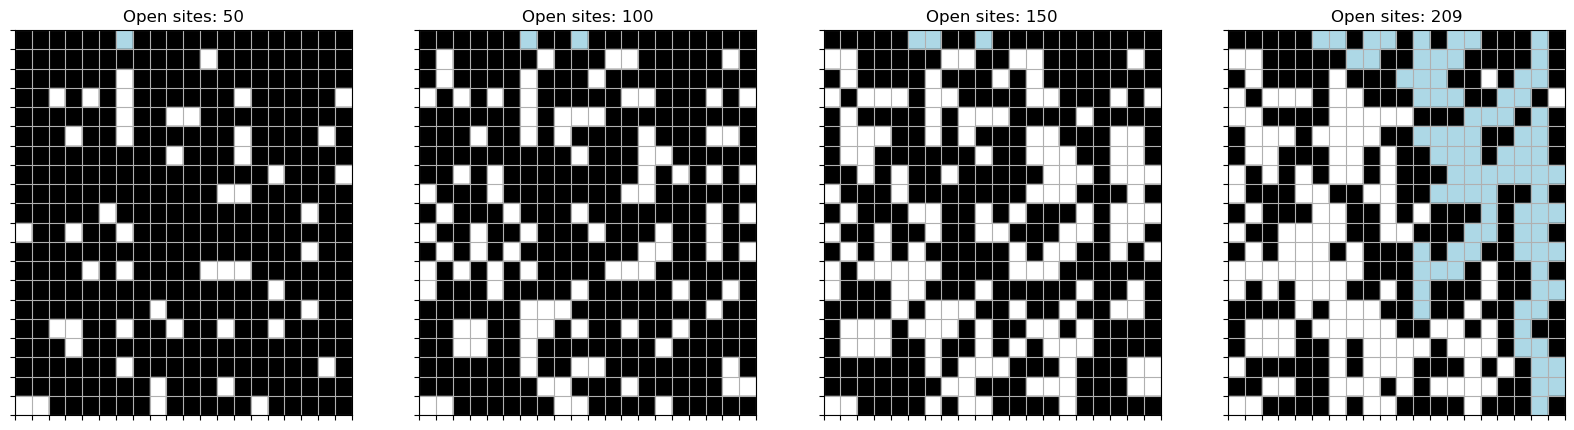

In [63]:
example = PercolationGrid(20)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    for k in range(50):
        if example.check_percolates(): break
        example.open_block()
    if i == 3:
        example.make_percolate()
    example.visualize(axs[i])
    axs[i].set_title(f'Open sites: {example.open_num}')

plt.show()


## 2.Monte Carlo simulation
In this part, we will conduct simulation with n=20,50, and 100, respectively. Let $x_t$ be the fraction of open sites in simulation $t$ and $s_t$ denote the number of opened sites, then we use sample mean to estimate the percolation threshold. We have
$$
x_t = \frac{s_t}{n^2}
$$

$$
p^* \approx \bar{x}=\frac{x_1+x_2+\ldots+x_T}{T}=\frac{s_1+s_2+\ldots+s_T}{n^2 T}
$$

In [74]:
T = 1000

def MC_Simulation(grid_len, times, progress_bar=True):
    '''
    grid_len: The length of the grid. The grid will be grid_len*grid_len
    times: The number of simulations: the T in x_bar=1/T*sum_{t=1}^T x_t
    '''
    open_num = 0
    
    if progress_bar:
        range_times =  tqdm(range(times))
    else:
        range_times = range(times)
        
    for i in range_times:
        grid = PercolationGrid(grid_len)
        open_num += grid.make_percolate()
    return (open_num/grid_len**2) / times
    
for n in [20, 50, 100]:
    print(f'Grid size: {n}-by-{n}')
    print(f'Estimated threshold: {MC_Simulation(n, T)}')
    print('-------------------------')

Grid size: 20-by-20


100%|██████████| 1000/1000 [00:10<00:00, 97.86it/s]


Estimated threshold: 0.594905
-------------------------
Grid size: 50-by-50


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


Estimated threshold: 0.5908848
-------------------------
Grid size: 100-by-100


100%|██████████| 1000/1000 [30:28<00:00,  1.83s/it]

Estimated threshold: 0.5926099
-------------------------


## 3.Comparison
In this section, we will compare the effect of **the number of simulation** on the results ( i.e. $T$ ). We will compare the results obtained with the number of simulation from 1 to 5000  (Because we found that after about 5,000 simulations the change was very small). And according to project specification, we have a prior that $p^* \approx 0.593$. Thus for each size of grid, we will show: for $t\in(0,5000]$
- The results of their estimation after t steps of simulations $\hat{p}^*_t$. 
- The gap $l(t)$ between their estimated results and $p^*=0.593$ after t steps of experiment. We will use $l(t)=|\hat{p}^*_t-p^*|$

Grid size: 20-by-20


100%|██████████| 5000/5000 [00:55<00:00, 89.99it/s] 


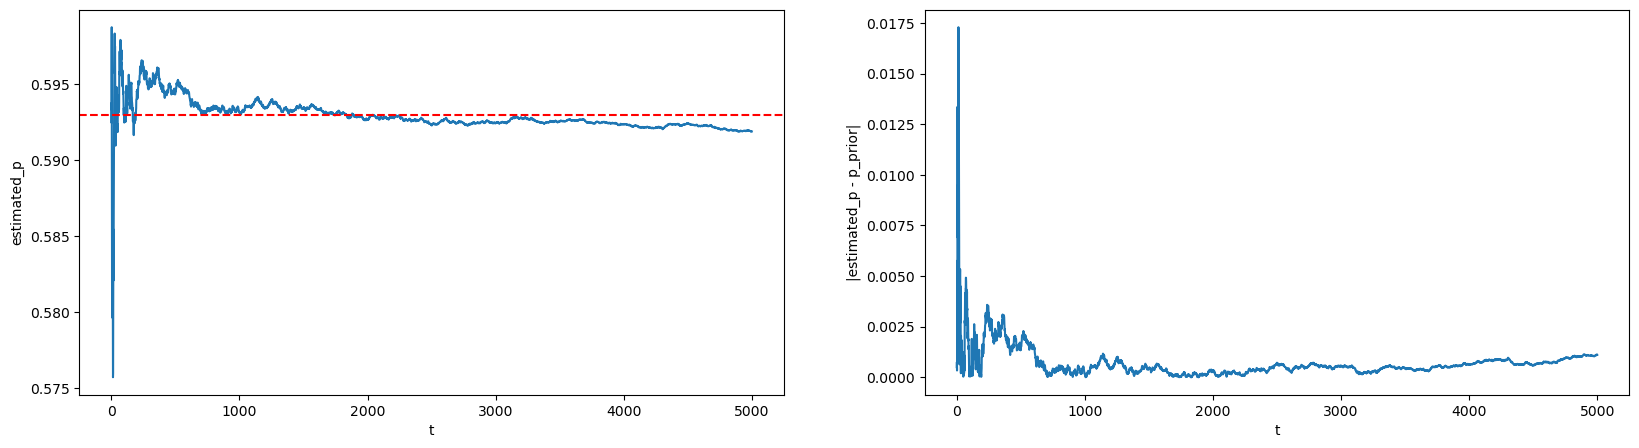

-------------------------
Grid size: 50-by-50


100%|██████████| 5000/5000 [15:44<00:00,  5.29it/s]


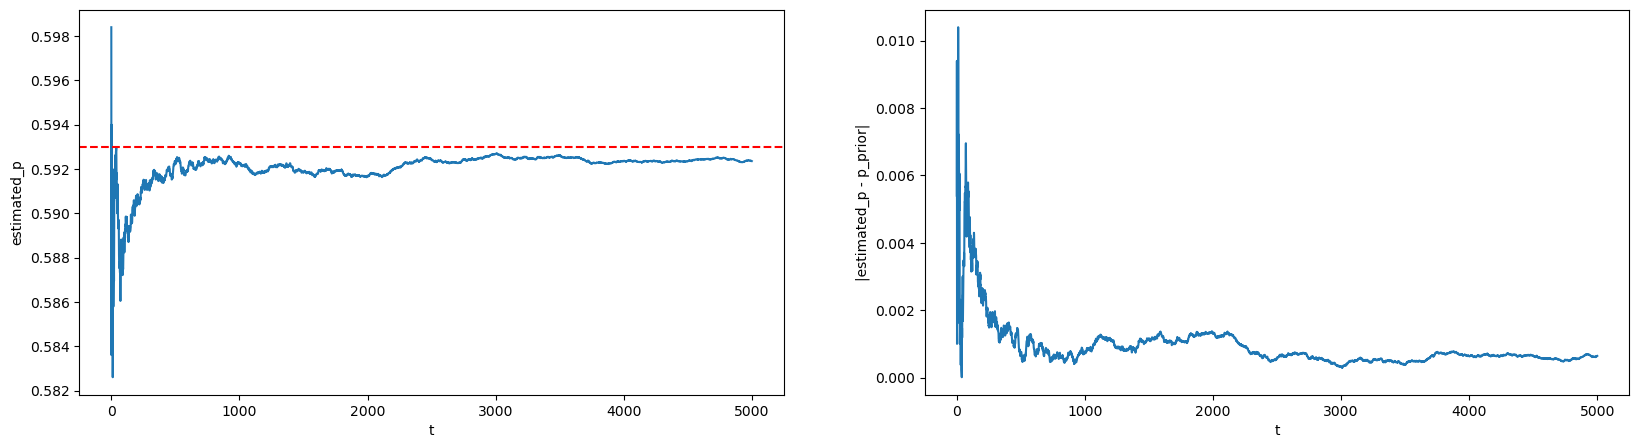

-------------------------
Grid size: 100-by-100


100%|██████████| 5000/5000 [2:04:45<00:00,  1.50s/it]  


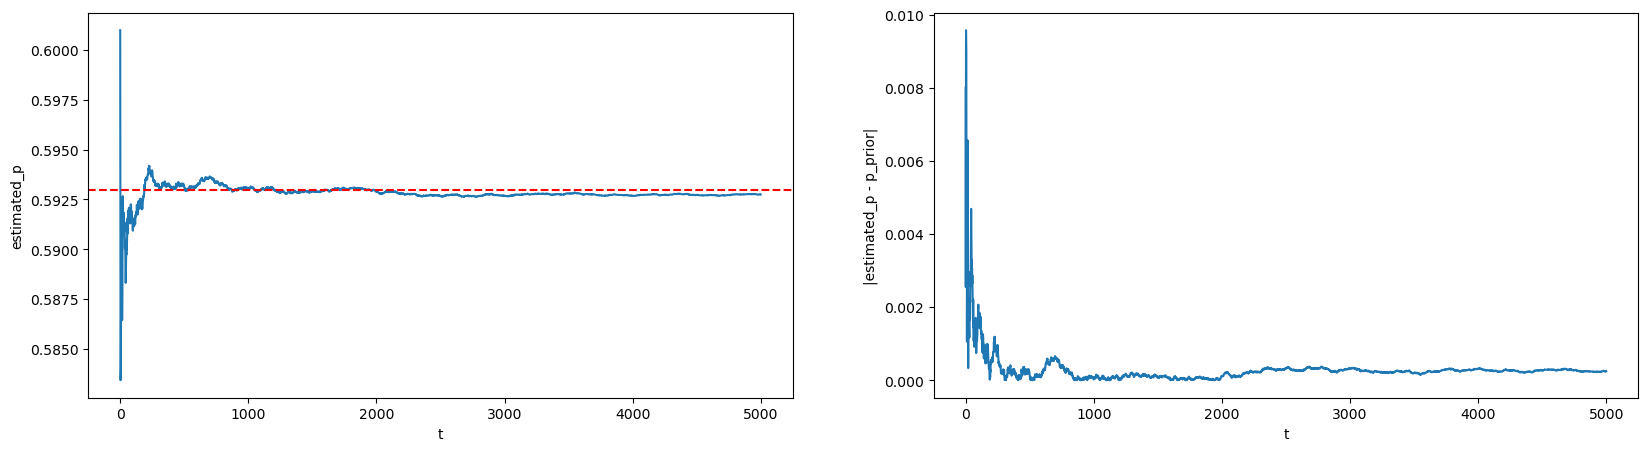

-------------------------


In [66]:
MAX_T = 5000
p_prior = 0.593

def MC_Simulation2(grid_len, times):
    open_num = 0
    estimated_p_t_values = []
    for t in tqdm(range(1,times+1)):
        grid = PercolationGrid(grid_len)
        grid.make_percolate()
        open_num += grid.open_num
        estimated_p_t = (open_num/grid_len**2) / t
        estimated_p_t_values.append(estimated_p_t)
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1,2,1)
    plt.plot(range(times), estimated_p_t_values)
    plt.axhline(y=p_prior, color='r', linestyle='--')
    plt.xlabel('t')
    plt.ylabel('estimated_p')
    

    
    plt.subplot(1,2,2)
    plt.plot(range(times), [abs(p - p_prior) for p in estimated_p_t_values])
    plt.xlabel('t')
    plt.ylabel('|estimated_p - p_prior|')
    plt.show()

     
for n in [20, 50, 100]:
    print(f'Grid size: {n}-by-{n}')
    MC_Simulation2(n, MAX_T)
    print('-------------------------')

It's not hard to see from the figure that:
- The more simulation times, the less changes the obtained results are, and the closer they are to our prior knowledge.
- When $n$ becomes large, we can get a stable and close to the prior knowledge of the answer with a smaller number of simulations


BUT this is not a good way to experiment! Because the result of t+1 trials will be related to the result of $t$ previous trials. Next we conduct more rigorous experiments, where for each $t$ we run the simulation $t$ times and take the average to get the $\hat{p}^*_t$. **Due to the time complexity**, we only conduct experiments with $n=20$, and $t\in (0,1500]$

100%|██████████| 1500/1500 [3:24:03<00:00,  8.16s/it]  


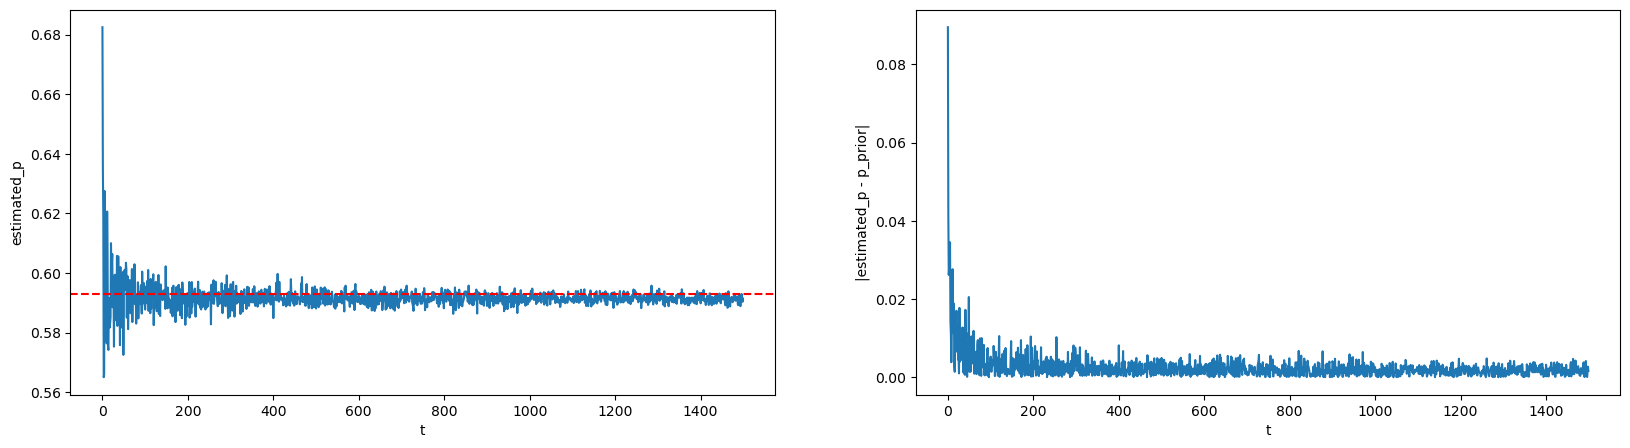

In [73]:
estimated_p_t_values = []
MAX_T = 1500

for T in tqdm(range(1,MAX_T+1)):
    estimated_p_t = MC_Simulation(20, T, progress_bar=False)
    estimated_p_t_values.append(estimated_p_t)

    
plt.figure(figsize=(20, 5))
    
plt.subplot(1,2,1)
plt.plot(range(MAX_T), estimated_p_t_values)
plt.axhline(y=p_prior, color='r', linestyle='--')
plt.xlabel('t')
plt.ylabel('estimated_p')

plt.subplot(1,2,2)
plt.plot(range(MAX_T), [abs(p - p_prior) for p in estimated_p_t_values])
plt.xlabel('t')
plt.ylabel('|estimated_p - p_prior|')
plt.show()    
    

It can be better seen from the above figure that the more simulation times, the more accurate results are obtained.

# Part II: Ising Model
-----------
## Task Allocation
+ Simulation and Math Proof (Task A~C): Chuyan Zhou
+ Visualization (Task B~C): Junye Wang
+ Exploration of physical phenomena (Task B~C): Junye Wang

## Description
In certain alloys, particularly those containing Fe, Co or Ni, the electrons have a tendency to align their spins in a common direction. This phenomenon is called **ferromagnetism**
and is characterized by the existence of a finite magnetization even in
the absence of a magnetic field. It has its origin in a genuinely quantum mechanical
effect known as the exchange interaction and related to the overlap between the wave
functions of neighboring electrons.

The spin ordering diminishes as the temperature of the sample increases and, above
a certain temperature $T_c$, the magnetization vanishes entirely. This is a phase transition
and $T_c$ is called the critical temperature or the Curie temperature. The
Curie temperature is named after Pierre Curie, who received the Nobel Prize in Physics
with his wife, Marie Curie. With their win, the Curies became the first ever married
couple to win the Nobel Prize, launching the Curie family legacy of five Nobel Prizes.

The Ising model is a mathematical model of ferromagnetism in statistical physics. The
Ising model was invented by the physicist Wilhelm Lenz in 1920, who gave it as a
problem to his student Ernst Ising. The one-dimensional Ising model was solved by
Ising alone in his 1924 thesis; however it has no phase transition. The two-dimensional
Ising model is much harder and was only given an analytic description much later,
by Lars Onsager in 1944. The two-dimensional Ising model is one of the simplest
statistical models to show a phase transition.

1. Now we describe a two-dimensional square-lattice Ising model: given an undirected
graph $G = (V,E)$, where $V$ is the set of vertex (site) and $E$ is the set of
edges. If $(v,w) ∈ E$, then we say vertex $v$ is the neighbor of vertex $w$, i.e., $v ∼ w$,
and vice versa. $G$ is an $n × n$ grid graph with $|V | = n^2$. Each vertex $v ∈ V$ is
associated with a discrete variable $σ_v$ such that $σ_k ∈ \{−1,+1\}$, representing the
vertex’s spin. An example of two-dimensional Ising model with n = 3 is illustrated
as follows:

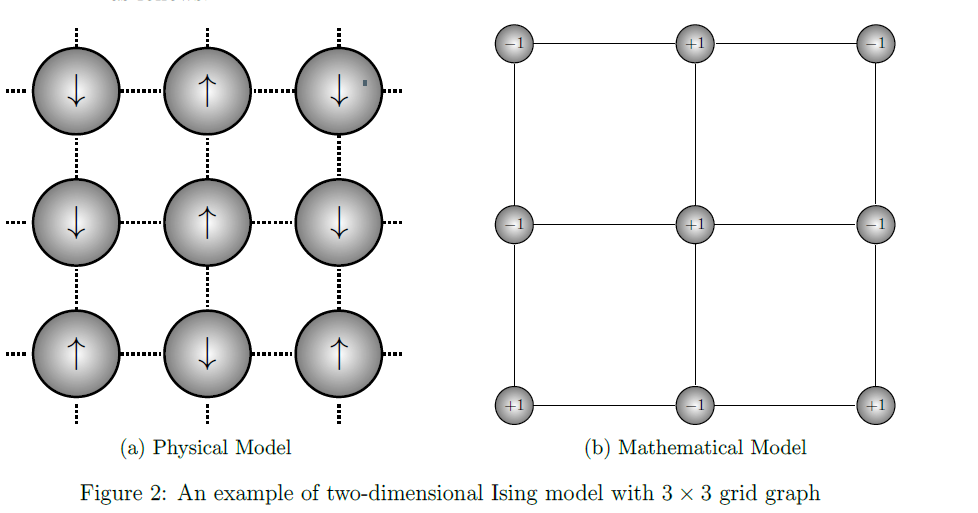

2. Define the spin configuration as $\boldsymbol \sigma = \{\sigma_v,v\in V\}$. The corresponding energy is
   $$
   H(\boldsymbol\sigma)=-\sum_{(v,w)\in E}\sigma_v\sigma_w.
   $$
   Define the set of all possible spin configurations as $\Omega$, and define the Gibbs distribution over $\Omega$ as follows:
   $$
   \pi_{\boldsymbol\sigma}={e^{-\beta H(\boldsymbol\sigma)}\over Z}, \forall \boldsymbol\sigma\in\Omega,
   $$
   where $\beta$ is the constant representing the inverse of the temperature, and $Z$ is the normalization constant (also called the partition function).



## Task A
Show that given all other vertices' spin value, the conditional distribution of vertex $k$'s spin is
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k})={1\over 1+e^{-2\beta(\sum_{v\sim k}\sigma_v)}},
\\P(\sigma_k=-1|\boldsymbol\sigma_{-k})={1\over 1+e^{2\beta(\sum_{v\sim k}\sigma_v)}},\tag{0.1}
$$
where
$$
\boldsymbol\sigma_{-k} = (σ_1, \cdots , σ_{k−1}, σ_{k+1},\cdots, σ_{|V |}).\tag{0.2}
$$

**Answer to Task A.**
$\newcommand{\bsigma}{\boldsymbol{\sigma}}$

*Proof.* From Gibbs distribution we know, $\forall\bsigma\in\Omega$, let the spin configuration $\bsigma$ be a vector of random variables, then we note $P(\boldsymbol \sigma)=\pi(\bsigma)=\pi_{\bsigma}$ representing the same probability, where
$$
{\pi}_{\bsigma}={e^{-\beta H(\bsigma)}\over Z}\propto e^{-\beta H(\bsigma)}=e^{\beta \sum_{(v,w)\in E}\sigma_v\sigma_w}.\tag {1.1}
$$
From Bayes' Rule and LOTP,
$$
\begin{align*}
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) &= {P(\sigma_k=+1,\boldsymbol\sigma_{-k})\over P(\boldsymbol\sigma_{-k})}
\\ & = {P(\sigma_k=+1,\boldsymbol\sigma_{-k})\over \sum_{\sigma_k\in\{+1,-1\}}P(\sigma_k,\boldsymbol\sigma_{-k})}.
\end{align*}
$$
For the denominator (normalization constant / partition function)
$$
\sum_{\sigma_k\in\{+1,-1\}}P(\sigma_k,\boldsymbol\sigma_{-k}) = P(\boldsymbol\sigma_{-k}),
$$
we know it's **independent** to $\sigma_k$, which means we can treat it as a function $\mathbf N(\bsigma_{-k})$, which means
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) = {P(\sigma_k=+1,\boldsymbol\sigma_{-k})\over \mathbf N(\bsigma_{-k})}\propto P(\sigma_k=+1,\boldsymbol\sigma_{-k}).\tag{1.2}
$$

Let $\bsigma_{+1}:=\bsigma_{-k}\cup\{\sigma_k|\sigma_k=+1\}$. We let the edge set connecting $k$ be $E_k$, and expand the terms of the joint probability corresponding to equation $(1.1)$:
$$
P(\sigma_k=+1,\boldsymbol\sigma_{-k}) = {\pi}_{\bsigma_{+1}}=e^{\beta\sum_{(k,u)\in E_k}\sigma_k\sigma_u}e^{\beta\sum_{(v,w)\in E\backslash E_k}\sigma_v\sigma_w},
$$
where $\sigma_k=+1$, and get the proportional form of the joint probability:
$$
P(\sigma_k=+1,\boldsymbol\sigma_{-k}) = e^{\beta\sum_{(k,u)\in E_k}\sigma_w}e^{\beta\sum_{(v,w)\in E\backslash E_k}\sigma_v\sigma_w}\propto e^{\beta\sum_{(k,u)\in E_k}\sigma_u}.\tag{1.3}
$$

From $(1.2)$ and $(1.3)$, we also treat $e^{\beta\sum_{(v,w)\in E\backslash E_k}\sigma_v\sigma_w}$ where all $\sigma_v$ and $\sigma_w$ given as a function $\mathbf {\hat N}(\bsigma_{-k})$, then the equation can be written in this way:
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) = {P(\sigma_k=+1,\boldsymbol\sigma_{-k})\over \mathbf N(\bsigma_{-k})} = {e^{\beta\sum_{(k,u)\in E_k}\sigma_u}\over \mathbf N(\bsigma_{-k})\mathbf{\hat N}(\bsigma_{-k})}\propto e^{\beta\sum_{(k,u)\in E_k}\sigma_u}.
$$
We simply note the normalization constant / partition function of the conditional probability: $\mathbf{\tilde N}(\bsigma_{-k})= \mathbf N(\bsigma_{-k})\mathbf{\hat N}(\bsigma_{-k})$, and simplify the notation:
$$
e^{\beta\sum_{(k,u)\in E_k}\sigma_u} = e^{\beta\sum_{v\sim k}\sigma_v},
$$
i.e. we have
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) = {e^{\beta\sum_{v\sim k}\sigma_v}\over \mathbf{\tilde N}(\bsigma_{-k})}.\tag{2.1}
$$
Similarly for $\sigma_k=-1$ (the proof of the equation below is just to change +1 into -1 for all time and get the different result), we have
$$
P(\sigma_k=-1|\boldsymbol\sigma_{-k}) =  {e^{-\beta\sum_{v\sim k}\sigma_v}\over \mathbf{\tilde N}(\bsigma_{-k})}.\tag{2.2}
$$

Because $\sigma_k\in\{-1,+1\}$, and
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) + P(\sigma_k=-1|\boldsymbol\sigma_{-k}) = 1,
$$
we can conclude
$$
\mathbf{\tilde N}(\bsigma_{-k}) = e^{-\beta\sum_{v\sim k}\sigma_v} + e^{\beta\sum_{v\sim k}\sigma_v}.\tag {2.3}
$$

Hence, by $(2.1),(2.2),(2.3)$, we have
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k}) = {e^{\beta\sum_{v\sim k}\sigma_v}\over e^{-\beta\sum_{v\sim k}\sigma_v} + e^{\beta\sum_{v\sim k}\sigma_v}}
= {1\over 1 + e^{-2\beta\sum_{v\sim k}\sigma_v}},
\\ P(\sigma_k=-1|\boldsymbol\sigma_{-k}) = {e^{-\beta\sum_{v\sim k}\sigma_v}\over e^{-\beta\sum_{v\sim k}\sigma_v} + e^{\beta\sum_{v\sim k}\sigma_v}}
= {1\over 1 + e^{2\beta\sum_{v\sim k}\sigma_v}}.\tag{3:Q.E.D.}
$$


## Task B,C
### Observation
$$
\newcommand{\indep}{\perp\!\!\!\perp}
$$
We know the graph $G$ is undirected, and also as a grid with $n\times n$ vertices. Ordinarily, we write undirected edges as things like $\{u,v\}$, but here we simplify it to $(u,v)\equiv (v,u)$, though same as directed ones.
 
**Definition 1.** We note $X\indep Y|Z$ as: A set of random variables (or one r.v.) $X$ is independent from another set of random variables (or one r.v.) $Y$ given $Z$ as condition set (or condition r.v.). When $Z=\emptyset$, the $\indep$ notation indicates unconditional independence (i.e. $X\indep Y$).

**Theorem 2. (Conditional Probability given All Other Variables)** Given all other vertices' spin value, the conditional distribution of vertex $k$'s spin is
$$
P(\sigma_k=+1|\boldsymbol\sigma_{-k})={1\over 1+e^{-2\beta(\sum_{v\sim k}\sigma_v)}},
\\P(\sigma_k=-1|\boldsymbol\sigma_{-k})={1\over 1+e^{2\beta(\sum_{v\sim k}\sigma_v)}},
$$
where
$$
\boldsymbol\sigma_{-k} = (σ_1, \cdots , σ_{k−1}, σ_{k+1},\cdots, σ_{|V |}).
$$
+ Shown by Task A.

**Definition 2.1. (Neighborhood)** $\forall k\in V$, we define the neighborhood of $k$ as
$$
\mathscr N(k):=\{w|k\sim w\}\equiv\{\text{Neighbors of }k\}.
$$

**Definition 2.2. (Close Neighbourhood)** $\forall k\in V$, we define the close neighborhood of $k$ as
$$
\mathscr N[k]:=\mathscr N(k)\cup \{k\}.
$$

**Corollary 2.1. (Local Markov Property)** $\forall k\in V$, in this Ising model, if $w\notin\mathscr N[k]$, then $\sigma_k\indep\sigma_w|\mathscr N(k)$.
+ *Proof.* Regardless of which value $x$ we assign to $\sigma_k$ in the support of $\sigma_k$ i.e. $\{-1,+1\}$, we can always notice that 
  $$
  P(\sigma_k=x|\boldsymbol\sigma_{-k}) = P(\sigma_k=x|\mathscr N(k)),
  $$
  where the RHS can be derived by a graph $G_{\mathscr N[k]}=(\mathscr N[k],E_{\mathscr N(k)})$ where $E_{\mathscr N(k)} := \{(w,k)|k\sim w\}\equiv \{(w,k)|k\in\mathscr N(k)\}$.
  So we can derive the conclusion from the equation.

**Definition 3.1. (Markov Network i.e. Markov Random Field)** Given an undirected graph $G=(V,E)$, a set of random variables $X=(X_v)_{v\in V}$ indexed by $V$ form a Markov random field, a.k.a. Markov Network w.r.t. $G$ if they satisfy the Markov properties:
1. Pairwise Markov Property: Any two non-adjacent variables are conditionally independent given all other variables.
2. Local Markov property: A variable is conditionally independent of all other variables given its neighbors (which is proven in **Corollary 2.1**.)
3. Global Markov property: Any two subsets of variables $A,B$ are conditionally independent given a separating subset (a subset through which every path from vertices of $A$ to ones of $B$ must pass)
*Note.* There is also a definition of the integration of MRF only encoding conditional independence and Gibbs Field for the Markov Network [here](https://www.cs.cmu.edu/~16831-f14/notes/F11/16831_lecture07_bneuman.pdf).

**Proposition 3.2.** If an undirected graph satisfies that every vertex (random variable) in this graph is assigned with nonzero probabilities,
then the 3 properties in **Definition 3.1** are equivalent.
*We omit the proof here.*

**Theorem 3. (Markov Network)** The Ising model graph $G$ is a Markov Network. 
*Proof.* It's obvious, from **Corollary 2.1** and **Definition 3.2**.

**Definition 4.1. (Clique)** In a Markov Network, a clique is any fully connected subset of the the graph (complete subgraph). All cliques forms a set of cliques $C$.

**Definition 4.2. (Max Clique)** In a Markov Network, a maximal clique (abbr. max clique) is a clique which is not a proper subgraph of any other cliques. All max cliques form a set of cliques $\hat C\subseteq C$.

**Definition 5.1. (Markov Blanket)** In the Ising model graph $G=(V,E)$ as a Markov Network, $\forall k\in V$, we say a set of $\sigma_v$ with some $v\in V$ is a Markov Blanket of $k$ (i.e. of $\sigma_k$) as $MB(k)$, if and only if it satisfies
$$
\sigma_k\indep \bsigma\backslash MB(k)|MB(k).
$$
+ In this general definition, we note that $MB(k)$ can also include redundant random variables, i.e. it's not unique. However, it doesn't matter because we will ignore this looseness, since the simulation method we are to use will ignore this, only sampling from any Markov Blankets (or the whole graph).

**Theorem 5.2.** $\forall k\in V$, $\mathscr N(k)$ is a Markov Blanket.
+ *Proof.* It's obvious to see from **Definition 5.1** and **Corollary 2.1**.




### Methods

The goal is, to sample multiple spin configurations (states), for each: $\bsigma$ from its distribution $\pi$ with support $\Omega$.
<!--  For the methods, we try Gibbs Sampling to simulate the phase transition (i.e. the 2D Ising model).  -->
We initially consider **Metropolis-Hastings Algorithm**, which needs a proposal distribution $Q$ to execute acceptance-rejection-like method, and initial config $\bsigma_0$ (we choose to randomly generate one in actual simulation), with the step count $N$. 
   
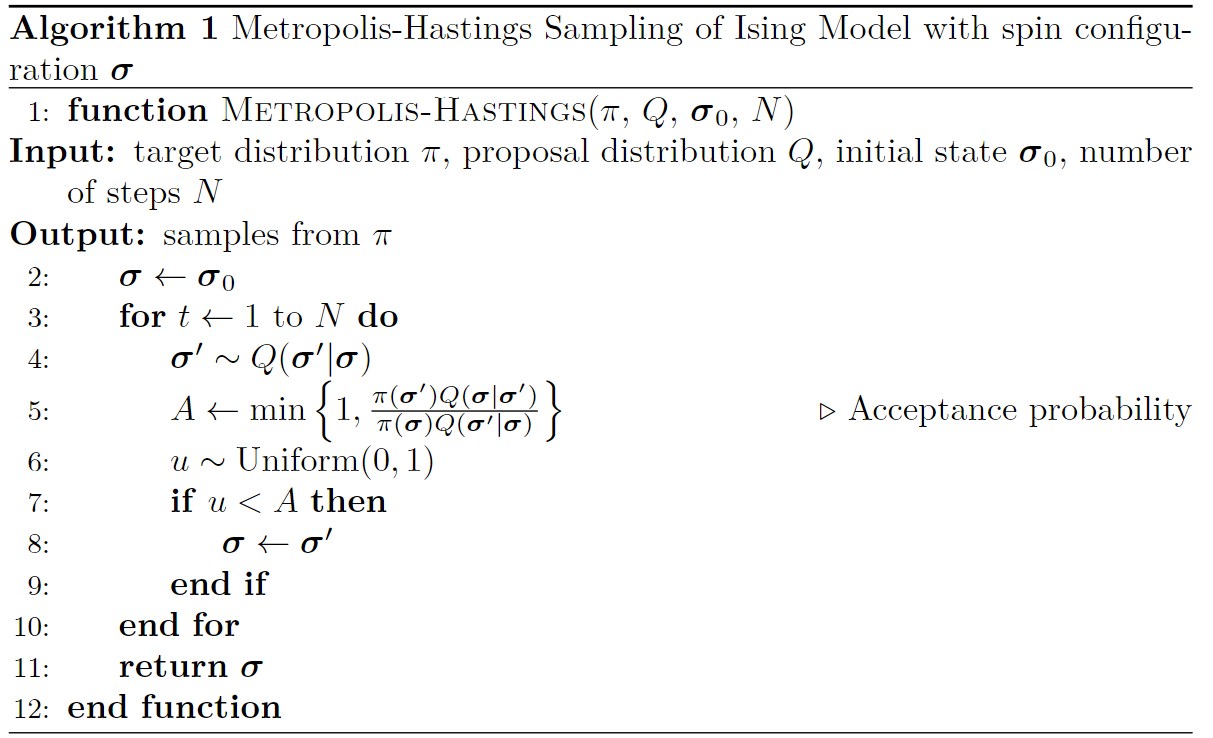

Within the algorithm, we can set $Q(\bsigma|\bsigma')=Q(\bsigma'|\bsigma)$ as symmetric probabilities.
+ Because we randomly initialize the config, it may be corresponding to a very low probability, which makes first $K$ iterations artificial. We can wait for these $K$ steps (**warm-up steps**) to get relatively accurate list of samples.
+ Also, for the convenience of computation, we can save the samples every $L$ steps.

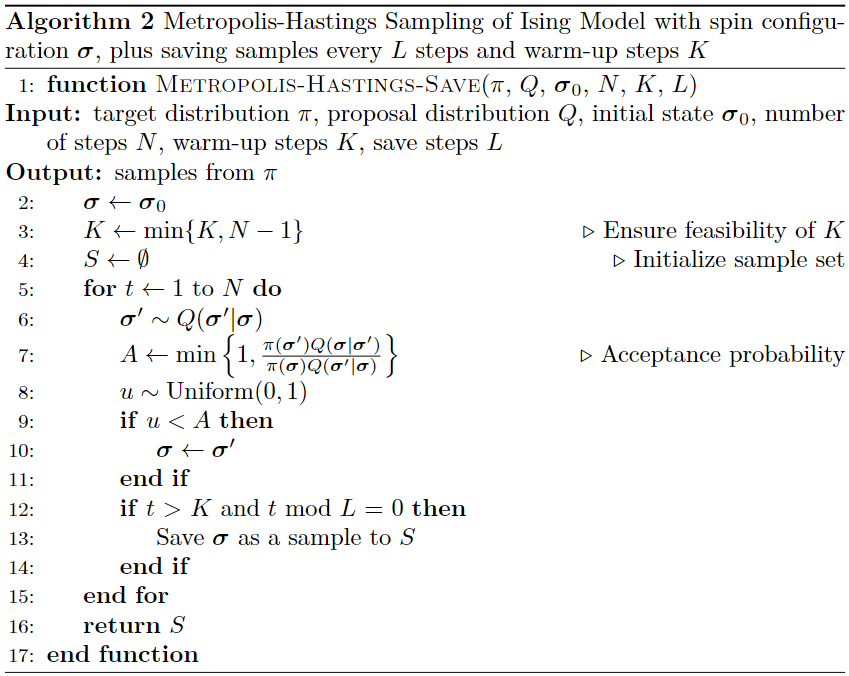

The reason we won't use Metropolis-Hastings in this Ising model simulation is that, though we can say the proposal $Q(\cdot|\bsigma')$ means the probability of transition from $\bsigma'$ to $\bsigma$ by flipping spins, so $Q(\bsigma|\bsigma')=Q(\bsigma'|\bsigma)$, but it may be hard to compute a new state because we don't only need to flip one spin, but also need to compute the probability of the new state.
So we need an algorithm to
+ Effectively sample as the Metropolis-Hastings Algorithm;
+ Efficiently compute the probability of the new state.

Hence, we consider **Gibbs Sampling**. For every time step $t$, we sample $\sigma_k$ from all other samples, i.e. $\bsigma_{-k}$, and update the state $\bsigma$ by $\sigma_k$.
The pace sampling from all other samples can be thus equivalently replaced by sampling from the Markov Blanket of $k$, e.g. $\mathscr N(k)$.
The tricks are similar to the Metropolis-Hastings Algorithm.
   + We can also use the warm-up steps, with randomly initialized $\bsigma_0$.
   + We can also use the Metropolis-Hastings Algorithm to sample $\sigma_k$ from $\mathscr N(k)$ (one-at-a-time), which is equivalent to the Gibbs Sampling.
Also, for this sampling algorithm, we only change one spin at a time, we want to choose which spin to change. Each step:
+ We can choose the spin randomly;
+ we can choose the spin with the highest probability to change, which is called **Importance Sampling**.
+ We can also choose the spin according to its location, from the left to the right, from the top to the bottom, called **Sweeping**.
Empirically, we choose the **Sweeping** method, and we can also let the step size $L=c|V|=c|\bsigma|$, where $c\in\mathbb N^+$ as a constant, and the warm-up steps $K$ as another multiple of $|V|$.
Here we show the standard Gibbs Sampling Algorithm using **Sweeping** method.
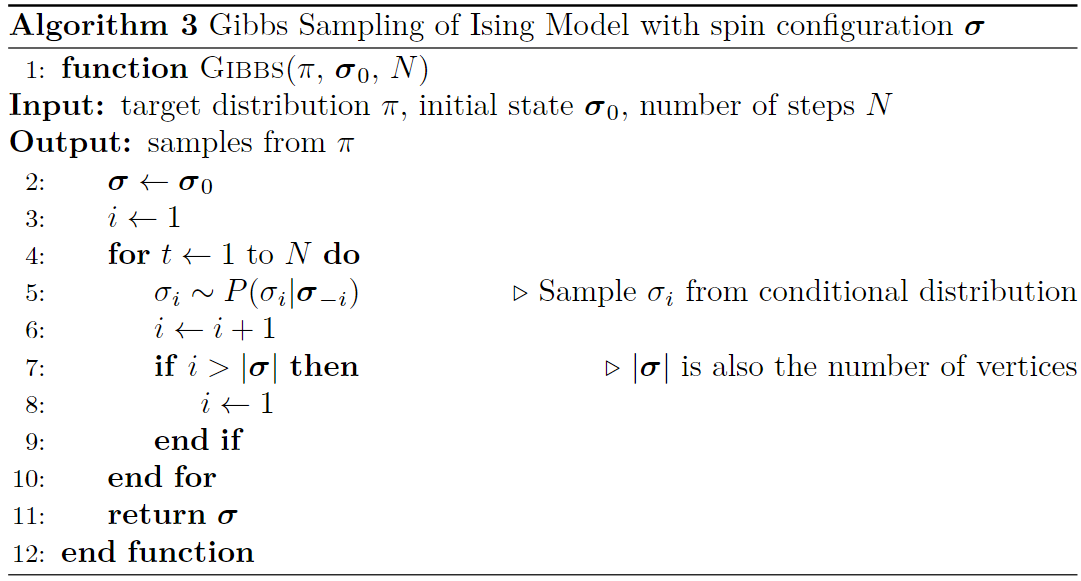

and the version we use:

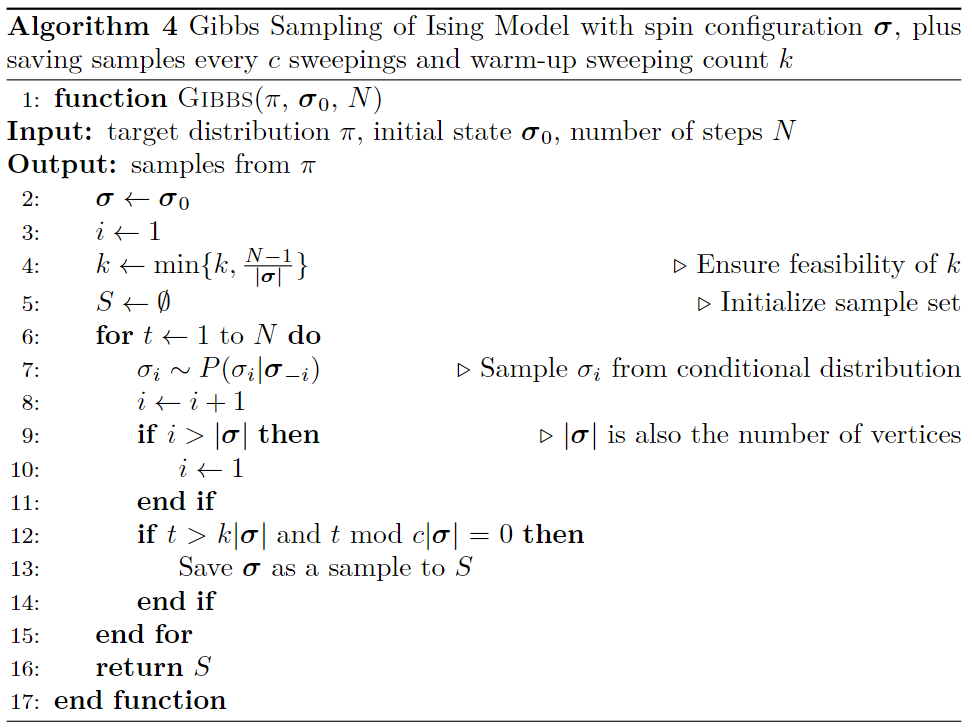

### Code & Visualization of Task B,C

100%|██████████| 4000000/4000000 [00:36<00:00, 109776.57it/s]


The number of samples is 95


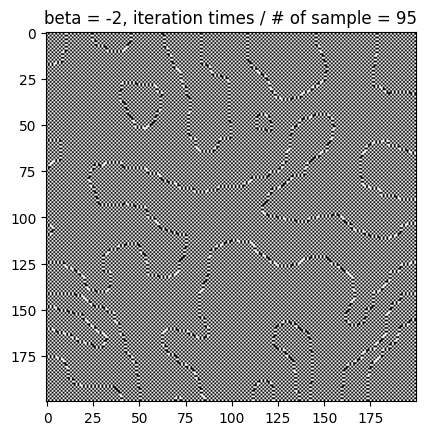

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math
from tqdm import tqdm

class IsingModel():
    '''Maintain a 2D Ising model with n*n spins and coupling constant beta'''
    def __init__(self, n, beta):
        # n: the size of the lattice
        # beta: the coupling constant
        self.n = n
        self.beta = beta
        # -1 or 1 lattice with spin config
        self._lattice_spin_config = np.random.choice([-1,1], size=(n,n)) # uniformly
        # print(self._lattice_spin_config)
        self._energy = self.get_energy()
        self._samples = []
    
    def get_energy(self):
        '''Return the energy of the current lattice'''
        energy = 0
        # we should pay attention to the boundary condition
        # get the edge list
        edge_set = set()
        for i in range(self.n):
            for j in range(self.n):
                if i != self.n-1:
                    edge_set.add(((i,j), (i+1,j)))
                if j != self.n-1:
                    edge_set.add(((i,j), (i,j+1)))
        # print(edge_set)
        # print(len(edge_set)) # 2*n*(n-1)
        # calculate the energy
        for edge in edge_set:
            energy += -self._lattice_spin_config[edge[0]]*self._lattice_spin_config[edge[1]]

        return energy
    
    def get_magnetization(self):
        '''Return the magnetization of the current lattice, but not used in the simulation'''
        return abs(np.sum(self._lattice_spin_config)/(self.n*self.n))
    
    def _get_neighbor(self, i, j):
        '''Return the neighbor of vertex (i,j)'''
        neighbor_list = []
        if i != 0:
            neighbor_list.append((i-1,j))
        if i != self.n-1:
            neighbor_list.append((i+1,j))
        if j != 0:
            neighbor_list.append((i,j-1))
        if j != self.n-1:
            neighbor_list.append((i,j+1))
        return neighbor_list
    
    def _get_neighbor_spins(self, i, j):
        '''Return the spin of the neighbors of vertex (i,j)'''
        neighbor_list = self._get_neighbor(i,j)
        neighbor_spin_list = []
        for neighbor in neighbor_list:
            neighbor_spin_list.append(self._lattice_spin_config[neighbor])
        return neighbor_spin_list
    
    def _get_neighbor_spin_sum(self, i, j):
        '''Return the spin sum of the neighbors of vertex (i,j), for cond prob calculation'''
        neighbor_spin_list = self._get_neighbor_spins(i,j)
        return np.sum(neighbor_spin_list)
        
    
    def _get_positive_conditional_probability(self, i, j):
        '''Return the conditional probability of vertex (i,j) for spin value +1 given its neighbor in the current lattice'''
        neighbor_spin_sum = self._get_neighbor_spin_sum(i,j)
        return 1/(1+math.exp(-2*self.beta*neighbor_spin_sum))
    
    def _get_next_in_sweeping(self, i, j):
        '''Return the next vertex in the sweeping order'''
        if j == self.n-1 and i == self.n-1:
            return (0, 0)
        elif j == self.n-1:
            return (i+1, 0)
        else:
            return (i, j+1)
    
    def gibbs_sampling(self, warmup_sweepings, save_sweeping_interval, steps):
        '''Return a list of samples of the lattice spin configuration using Gibbs sampling'''
        # steps: steps = max_sweepings * n**2, but we explicitly specify it.
        self._samples = []
        warmup_sweepings = min(warmup_sweepings, (steps -1)/ self.n**2)
        warmup_steps = warmup_sweepings*self.n**2
        
        save_steps = save_sweeping_interval*self.n**2
        i, j = 0, 0
        # for sweep, 
        for step in tqdm(range(steps)):
            # for each vertex, sample its spin value
            # sample the spin value of vertex (i,j)
            p = self._get_positive_conditional_probability(i,j)
            if rand.random() < p:
                self._lattice_spin_config[(i,j)] = 1
            else:
                self._lattice_spin_config[(i,j)] = -1
            # move to the next vertex
            i, j = self._get_next_in_sweeping(i,j)
            # if we have finished a sweeping, we should save the sample
            if step >= warmup_steps and step % save_steps == 0:
                # print('step', step, 'sample', self._lattice_spin_config)
                self._samples.append(self._lattice_spin_config.copy())
    def gibbs_sampling_max_sweepings(self, warmup_sweepings, save_sweeping_interval, max_sweepings):
        self.gibbs_sampling(warmup_sweepings, save_sweeping_interval=save_sweeping_interval, steps=max_sweepings*self.n**2)
    def simulate(self, warmup_sweepings, save_sweeping_interval, max_sweepings):
        '''Simulate the Ising model using Gibbs sampling'''
        self._lattice_spin_config = np.random.choice([-1,1], size=(self.n,self.n)) # uniformly
        self.gibbs_sampling_max_sweepings(warmup_sweepings, save_sweeping_interval, max_sweepings)
        
    def plot_samples(self, mode='print_and_last', lasts=1):
        '''Plot the samples'''
        print('The number of samples is', len(self._samples))
        if mode == 'print_and_all':
            for sample in self._samples:
                print(sample)
            return
        elif mode == 'print_and_last':
            for sample in self._samples[-lasts:]:
                print(sample)
            return
        elif mode == 'plot_and_last':
            for sample in self._samples[-lasts:]:
                plt.imshow(sample, cmap='gray', vmin=-1, vmax=1) 
                # also plot beta and sample iteration times
                plt.title('beta = ' + str(self.beta) + ', iteration times / # of sample = ' + str(len(self._samples)))
                plt.show()
            return

# Example Usage
ising_model = IsingModel(n=200, beta=-2)
ising_model.simulate(warmup_sweepings=5, save_sweeping_interval=1, max_sweepings=100)
ising_model.plot_samples(mode='plot_and_last', lasts=1)


To visualize the simulation results, we want to plot them as animations in gif form.
The code is shown below.

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

class IsingModel():
    def __init__(self, n, beta):
        self.n = n
        self.beta = beta
        self._lattice_spin_config = np.random.choice([-1, 1], size=(n, n))
        self._energy = self.get_energy()
        self._samples = []

    def get_energy(self):
        energy = 0
        edge_set = set()
        for i in range(self.n):
            for j in range(self.n):
                if i != self.n - 1:
                    edge_set.add(((i, j), (i + 1, j)))
                if j != self.n - 1:
                    edge_set.add(((i, j), (i, j + 1)))

        for edge in edge_set:
            energy += -self._lattice_spin_config[edge[0]] * self._lattice_spin_config[edge[1]]

        return energy

    def _get_neighbor(self, i, j):
        neighbor_list = []
        if i != 0:
            neighbor_list.append((i - 1, j))
        if i != self.n - 1:
            neighbor_list.append((i + 1, j))
        if j != 0:
            neighbor_list.append((i, j - 1))
        if j != self.n - 1:
            neighbor_list.append((i, j + 1))
        return neighbor_list

    def _get_neighbor_spins(self, i, j):
        neighbor_list = self._get_neighbor(i, j)
        neighbor_spin_list = []
        for neighbor in neighbor_list:
            neighbor_spin_list.append(self._lattice_spin_config[neighbor])
        return neighbor_spin_list

    def _get_neighbor_spin_sum(self, i, j):
        neighbor_spin_list = self._get_neighbor_spins(i, j)
        return np.sum(neighbor_spin_list)

    def _get_positive_conditional_probability(self, i, j):
        neighbor_spin_sum = self._get_neighbor_spin_sum(i, j)
        return 1 / (1 + math.exp(-2 * self.beta * neighbor_spin_sum))

    def _get_next_in_sweeping(self, i, j):
        if j == self.n - 1 and i == self.n - 1:
            return (0, 0)
        elif j == self.n - 1:
            return (i + 1, 0)
        else:
            return (i, j + 1)

    def gibbs_sampling(self, warmup_sweepings, save_sweeping_interval, steps):
        self._samples = []
        warmup_sweepings = min(warmup_sweepings, (steps - 1) / self.n ** 2)
        warmup_steps = warmup_sweepings * self.n ** 2
        save_steps = save_sweeping_interval * self.n ** 2
        i, j = 0, 0

        # 使用 tqdm 进行循环进度显示
        for step in tqdm(range(steps), desc="Gibbs Sampling"):
            p = self._get_positive_conditional_probability(i, j)
            if rand.random() < p:
                self._lattice_spin_config[(i, j)] = 1
            else:
                self._lattice_spin_config[(i, j)] = -1

            i, j = self._get_next_in_sweeping(i, j)

            if step >= warmup_steps and step % save_steps == 0:
                self._samples.append(self._lattice_spin_config.copy())

    def gibbs_sampling_max_sweepings(self, warmup_sweepings, save_sweeping_interval, max_sweepings):
        self.gibbs_sampling(warmup_sweepings, save_sweeping_interval=save_sweeping_interval, steps=max_sweepings * self.n ** 2)

    def simulate(self, warmup_sweepings, save_sweeping_interval, max_sweepings):
        self._lattice_spin_config = np.random.choice([-1, 1], size=(self.n, self.n))
        self.gibbs_sampling_max_sweepings(warmup_sweepings, save_sweeping_interval, max_sweepings)

    def plot_samples(self, mode='print_and_last', lasts=1):
        print('The number of samples is', len(self._samples))
        if mode == 'print_and_all':
            for sample in self._samples:
                print(sample)
            return
        elif mode == 'print_and_last':
            for sample in self._samples[-lasts:]:
                print(sample)
            return
        elif mode == 'plot_and_last':
            for sample in self._samples[-lasts:]:
                plt.imshow(sample)
                plt.show()
            return

    def animate_samples(self, interval, save_path=None):
        fig, ax = plt.subplots()

        def update(frame):
            ax.clear()
            im = ax.imshow(self._samples[frame], cmap='Reds', interpolation='bilinear', extent=(0, self.n, 0, self.n), vmin=-1, vmax=1)

            ax.set_title(f'Step {frame}')

            n_beta_text = f'n = {self.n}, β = {self.beta:.3f}'
                    
            ax.text(0.02, 0.98, n_beta_text, transform=fig.transFigure,
                    fontsize=10, horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

                    
        animation = FuncAnimation(fig, update, frames=len(self._samples), interval=interval, repeat=False)

        if save_path:
            absolute_path = os.path.abspath(save_path)
            animation.save(absolute_path, writer='pillow', fps=1000 // interval)
            print(f"Animation saved at: {absolute_path}")
        else:
            plt.show()

betas = [-1, 0, 0.441, 0.8]
n = 100

for beta_value in betas:
    ising_model = IsingModel(n, beta=beta_value)
    ising_model.simulate(warmup_sweepings=5, save_sweeping_interval=1, max_sweepings=100)

    # Set the interval for displaying each frame in milliseconds
    animation_interval = 500

    # Generate and display the animation with n and β values
    save_path = f'animation_graph/ising_model_animation_n{n}_beta{beta_value:.3f}.gif'
    ising_model.animate_samples(interval=animation_interval, save_path=save_path)

![image](animation_graph\ising_model_animation_n100_beta-1.000.gif)

![image](animation_graph\ising_model_animation_n100_beta0.000.gif)

![image](animation_graph\ising_model_animation_n100_beta0.441.gif)

![image](animation_graph\ising_model_animation_n100_beta0.800.gif)

![image](animation_graph\ising_model_animation_n300_beta-5.000.gif)

![image](animation_graph\ising_model_animation_n300_beta0.200.gif)

![image](animation_graph\ising_model_animation_n300_beta0.441.gif)

![image](animation_graph\ising_model_animation_n300_beta0.600.gif)

In order to reflect the relationship and trend of energy and magnetization with temperature in the process of phase transition, we plot the corresponding energy and magnetization at different temperatures into statistical curves, which is convenient for more intuitive understanding of the influencing factors of phase transition.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math
from tqdm import tqdm  # Import tqdm for the progress bar

class IsingModel():
    '''Maintain a 2D Ising model with n*n spins and coupling constant beta'''
    def __init__(self, n, beta):
        # n: the size of the lattice
        # beta: the coupling constant
        self.n = n
        self.beta = beta
        # -1 or 1 lattice with spin config
        self._lattice_spin_config = np.random.choice([-1,1], size=(n,n)) # uniformly
        # print(self._lattice_spin_config)
        self._energy = self.get_energy()
        self._samples = []
    
    def get_energy(self):
        '''Return the energy of the current lattice'''
        energy = 0
        # we should pay attention to the boundary condition
        # get the edge list
        edge_set = set()
        for i in range(self.n):
            for j in range(self.n):
                if i != self.n-1:
                    edge_set.add(((i,j), (i+1,j)))
                if j != self.n-1:
                    edge_set.add(((i,j), (i,j+1)))
        # print(edge_set)
        # print(len(edge_set)) # 2*n*(n-1)
        # calculate the energy
        for edge in edge_set:
            energy += -self._lattice_spin_config[edge[0]]*self._lattice_spin_config[edge[1]]

        return energy
    
    def get_magnetization(self):
        '''Return the magnetization of the current lattice, but not used in the simulation'''
        return abs(np.sum(self._lattice_spin_config)/(self.n*self.n))
    
    def _get_neighbor(self, i, j):
        '''Return the neighbor of vertex (i,j)'''
        neighbor_list = []
        if i != 0:
            neighbor_list.append((i-1,j))
        if i != self.n-1:
            neighbor_list.append((i+1,j))
        if j != 0:
            neighbor_list.append((i,j-1))
        if j != self.n-1:
            neighbor_list.append((i,j+1))
        return neighbor_list
    
    def _get_neighbor_spins(self, i, j):
        '''Return the spin of the neighbors of vertex (i,j)'''
        neighbor_list = self._get_neighbor(i,j)
        neighbor_spin_list = []
        for neighbor in neighbor_list:
            neighbor_spin_list.append(self._lattice_spin_config[neighbor])
        return neighbor_spin_list
    
    def _get_neighbor_spin_sum(self, i, j):
        '''Return the spin sum of the neighbors of vertex (i,j), for cond prob calculation'''
        neighbor_spin_list = self._get_neighbor_spins(i,j)
        return np.sum(neighbor_spin_list)
        
    
    def _get_positive_conditional_probability(self, i, j):
        '''Return the conditional probability of vertex (i,j) for spin value +1 given its neighbor in the current lattice'''
        neighbor_spin_sum = self._get_neighbor_spin_sum(i,j)
        return 1/(1+math.exp(-2*self.beta*neighbor_spin_sum))
    
    def _get_next_in_sweeping(self, i, j):
        '''Return the next vertex in the sweeping order'''
        if j == self.n-1 and i == self.n-1:
            return (0, 0)
        elif j == self.n-1:
            return (i+1, 0)
        else:
            return (i, j+1)
    
    def gibbs_sampling(self, warmup_sweepings, save_sweeping_interval, steps):
        '''Return a list of samples of the lattice spin configuration using Gibbs sampling'''
        # steps: steps = max_sweepings * n**2, but we explicitly specify it.
        self._samples = []
        warmup_sweepings = min(warmup_sweepings, (steps -1)/ self.n**2)
        warmup_steps = warmup_sweepings*self.n**2
        
        save_steps = save_sweeping_interval*self.n**2
        i, j = 0, 0
        # for sweep, 
        for step in tqdm(range(steps)):
            # for each vertex, sample its spin value
            # sample the spin value of vertex (i,j)
            p = self._get_positive_conditional_probability(i,j)
            if rand.random() < p:
                self._lattice_spin_config[(i,j)] = 1
            else:
                self._lattice_spin_config[(i,j)] = -1
            # move to the next vertex
            i, j = self._get_next_in_sweeping(i,j)
            # if we have finished a sweeping, we should save the sample
            if step >= warmup_steps and step % save_steps == 0:
                # print('step', step, 'sample', self._lattice_spin_config)
                self._samples.append(self._lattice_spin_config.copy())

    def gibbs_sampling_max_sweepings(self, warmup_sweepings, save_sweeping_interval, max_sweepings):
        self.gibbs_sampling(warmup_sweepings, save_sweeping_interval=save_sweeping_interval, steps=max_sweepings*self.n**2)

    def simulate(self, warmup_sweepings, save_sweeping_interval, max_sweepings, temperature_range):
        '''Simulate the Ising model using Gibbs sampling over a range of temperatures'''
        temperatures = np.linspace(temperature_range[0], temperature_range[1], 200)
        energies = []
        magnetizations = []

        for temp in tqdm(temperatures, desc='Temperature Progress'):
            print("Temperature: ", temp)
            self.beta = 1/temp
            self._lattice_spin_config = np.random.choice([-1, 1], size=(self.n, self.n))  # Reset initial configuration
            self.gibbs_sampling_max_sweepings(warmup_sweepings, save_sweeping_interval, max_sweepings)
            energies.append(self.get_energy())
            magnetizations.append(self.get_magnetization())
            print("Magnetization: ", self.get_magnetization())

        self.plot_energy_and_magnetization(temperatures, energies, magnetizations)

    def plot_energy_and_magnetization(self, temperatures, energies, magnetizations):
        '''Plot energy and magnetization as functions of temperature'''
        plt.figure(figsize=(10, 6))

        plt.subplot(2, 1, 1)
        plt.plot(temperatures, energies, label='Energy')
        plt.title('Energy vs Temperature')
        plt.xlabel('Temperature')
        plt.ylabel('Energy')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(temperatures, magnetizations, label='Magnetization')
        plt.title('Magnetization vs Temperature')
        plt.xlabel('Temperature')
        plt.ylabel('Magnetization')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Example Usage
ising_model = IsingModel(n=20, beta=0.8)
ising_model.simulate(warmup_sweepings=5, save_sweeping_interval=1, max_sweepings=300, temperature_range=(0.1, 6))


![image](statistic_plot\plot_temp.png)

## Energy Variation with Temperature:
High-Temperature Region (Weak Coupling): At high temperatures, thermal fluctuations become significant. In the Ising model, this randomness leads to random spin flips, causing neighboring spins to be uncorrelated. Due to the coupling (exchange interaction) between adjacent spins, this randomness results in higher energy states.

Near the Critical Temperature: As the temperature decreases, the system's energy gradually decreases. Around the critical temperature, a competition between thermal fluctuations and ordered arrangements becomes prominent. This may lead to a phase transition, transitioning from a disordered phase at high temperatures to an ordered phase at lower temperatures, accompanied by a significant decrease in energy.

Low-Temperature Region (Strong Coupling): At low temperatures, the coupling energy dominates. Spins tend to align more ordered to minimize the energy between adjacent spins. This leads to a lower total energy, and the system may approach a stable ground state.

## Magnetization Variation with Temperature:
High-Temperature Region: At high temperatures, thermal fluctuations make spins more likely to flip, resulting in a smaller total magnetization. The random nature of spin orientations leads to an overall trend towards zero magnetization.

Near the Critical Temperature: Around the critical temperature, the magnetization may exhibit a sharp change as the system undergoes a phase transition. The transition from a disordered to an ordered phase can cause a significant increase in the total magnetization.

Low-Temperature Region: As the temperature decreases, the system tends to adopt a more ordered state, leading to an increase in the total magnetization. At low temperatures, the system may reach a stable state with maximum magnetization.

In summary, the 2D Ising model displays different behaviors of energy and magnetization at different temperatures. These variations are closely tied to thermal fluctuations, phase transitions, and the interplay of spin interactions. The system undergoes a transition from disorder to order with changing temperature, resulting in observable changes in energy and magnetization.